In [1]:
import copy
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch
# %matplotlib inline

import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample

from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from src.model.loss import spectral_loss
from synth.synth_architecture import SynthModular
# from config import SynthConfig
from src.main_hp_search_dec_only import configure_experiment

# from config import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants

%matplotlib inline
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Setup experiment

exp_name = 'del_visualization'
dataset_name = 'fm_saw_single'
config_name = r'C:\Users\noamk\PycharmProjects\ai_synth\configs\lfo_saw_single_synth_config_hp_search.yaml'
device = 'cuda'
# resample_op = Resample(orig_freq=16000, new_freq=50).to('cpu')

cfg = configure_experiment(exp_name, dataset_name, config_name, debug=True)

# synth = SynthModular(synth_cfg=synth_cfg, sample_rate=cfg.sample_rate, device=device, num_sounds=1,
#                      signal_duration_sec=cfg.signal_duration_sec, preset=synth_cfg.preset)
synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

# dataset = AiSynthDataset(cfg.train_parameters_file, cfg.train_audio_dir, device)
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)



Deleting previous experiment...


In [3]:
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)

target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(1, 1): {'operation': 'lfo', 'parameters': {'active': True, 'output': [(0, 2)], 'freq': 14.285357442943784, 'waveform': 'square'}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': True, 'active': True, 'amp_c': 0.6187255599871848, 'freq_c': 349.22823143300377, 'mod_index': 0.02403950683025824}}}


In [4]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants, device=device)

In [5]:
loss_handler.spectrogram_ops

{'2048_spectrogram': Spectrogram(),
 '1024_spectrogram': Spectrogram(),
 '512_spectrogram': Spectrogram(),
 '256_spectrogram': Spectrogram(),
 '128_spectrogram': Spectrogram(),
 '64_spectrogram': Spectrogram()}

In [6]:
fm_freq_vals = np.linspace(0, 1200, 1200)

losses1 = []
for freq_val in fm_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'freq_c': freq_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses1.append(loss_val.detach().cpu().numpy().item())

print(losses1)


Missing amp param in Oscillator module lfo. Assuming fixed amp. Please check Synth structure if this is unexpected.
[7.761412620544434, 8.049026489257812, 8.081942558288574, 8.02045726776123, 8.002314567565918, 7.997732162475586, 8.003012657165527, 7.937865257263184, 7.98357629776001, 8.075998306274414, 8.07056999206543, 7.973498344421387, 7.981476783752441, 7.939383506774902, 7.928469657897949, 8.336313247680664, 8.11166763305664, 8.16132640838623, 8.103856086730957, 8.147134780883789, 8.078352928161621, 7.997298717498779, 8.101786613464355, 8.055622100830078, 8.03620719909668, 8.105104446411133, 8.009471893310547, 7.983377456665039, 7.845444202423096, 7.998534679412842, 8.138127326965332, 8.128439903259277, 8.12024974822998, 8.089667320251465, 8.112092971801758, 8.05219554901123, 8.221578598022461, 8.138630867004395, 8.187239646911621, 8.128120422363281, 8.011194229125977, 7.9746856689453125, 7.729076385498047, 9.262063980102539, 8.625298500061035, 8.52844524383545, 8.444687843322754

In [7]:
# matplotlib.use('Qt5Agg')



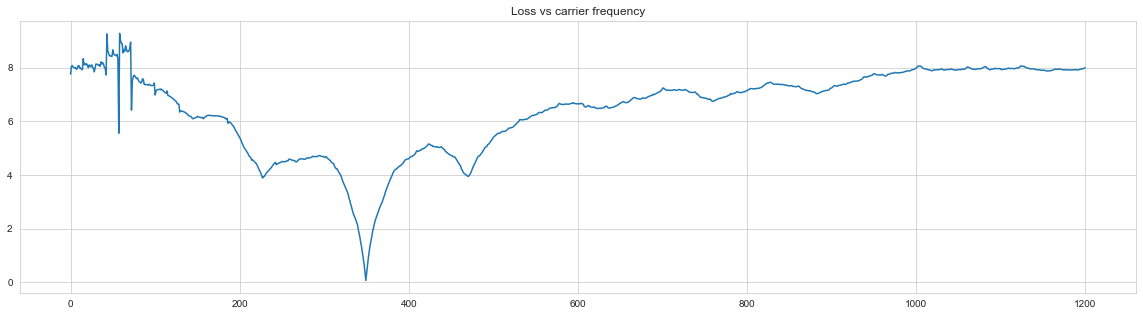

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(fm_freq_vals, losses1)
plt.title("Loss vs carrier frequency")
plt.show()

In [9]:
lfo_freq_vals = np.linspace(0, 15, 100)

losses2 = []
for freq_val in lfo_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(1, 1)]['parameters'].update({'freq': freq_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses2.append(loss_val.detach().cpu().numpy().item())

print(losses2)

[5.364941120147705, 3.8084161281585693, 3.8084161281585693, 3.8084161281585693, 3.5773956775665283, 3.023350954055786, 2.5269486904144287, 2.164762020111084, 1.9403671026229858, 1.828358769416809, 1.7801064252853394, 1.7129384279251099, 1.6218974590301514, 1.5425583124160767, 1.4695892333984375, 1.406593918800354, 1.376388669013977, 1.3523980379104614, 1.3196693658828735, 1.2865664958953857, 1.2431901693344116, 1.2140867710113525, 1.184145212173462, 1.157541275024414, 1.1416455507278442, 1.115251064300537, 1.0838085412979126, 1.0605401992797852, 1.0387264490127563, 1.0220204591751099, 1.0046674013137817, 0.9851840734481812, 0.9599894285202026, 0.9414739012718201, 0.9214686751365662, 0.9145793914794922, 0.8934109210968018, 0.8801649212837219, 0.8572936058044434, 0.8367188572883606, 0.8274094462394714, 0.7967896461486816, 0.7908194661140442, 0.7875821590423584, 0.7555660009384155, 0.7359322905540466, 0.732964813709259, 0.7071990966796875, 0.6952511072158813, 0.6816571950912476, 0.6861738

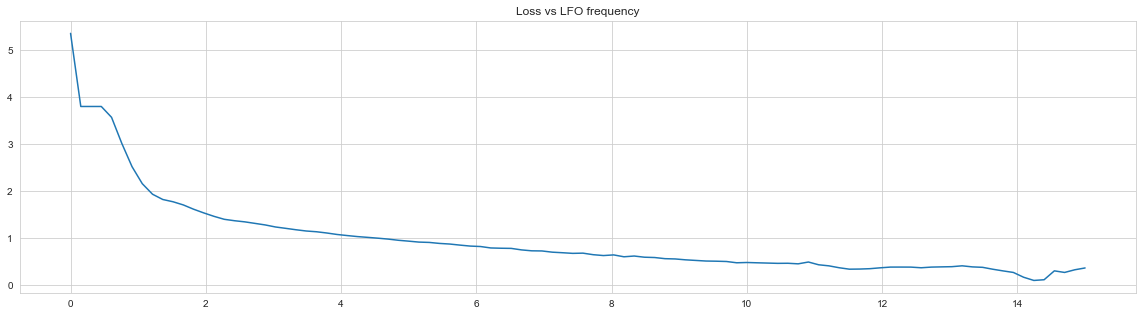

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(lfo_freq_vals, losses2)
plt.title("Loss vs LFO frequency")

plt.show()

In [11]:
amp_vals = np.linspace(0, 1, 100)

losses3 = []
for amp_val in amp_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'amp_c': amp_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses3.append(loss_val.detach().cpu().numpy().item())

print(losses3)


[4.657316207885742, 4.656075477600098, 4.6523518562316895, 4.646144866943359, 4.63745641708374, 4.626284599304199, 4.612630367279053, 4.596494197845459, 4.577874183654785, 4.5567731857299805, 4.533188343048096, 4.507122039794922, 4.478571891784668, 4.447540283203125, 4.414026260375977, 4.378028869628906, 4.3395490646362305, 4.298586845397949, 4.2551422119140625, 4.20921516418457, 4.1608052253723145, 4.109912872314453, 4.056537628173828, 4.000679969787598, 3.9423398971557617, 3.881517171859741, 3.8182120323181152, 3.7524242401123047, 3.6841540336608887, 3.613401174545288, 3.540165901184082, 3.4644479751586914, 3.386247158050537, 3.3055639266967773, 3.222398281097412, 3.1367502212524414, 3.048619508743286, 2.958005905151367, 2.864910125732422, 2.769331455230713, 2.6712708473205566, 2.5707268714904785, 2.467700958251953, 2.362192392349243, 2.2542009353637695, 2.1437273025512695, 2.030771017074585, 1.9153319597244263, 1.797410249710083, 1.6770066022872925, 1.5541200637817383, 1.42875087261

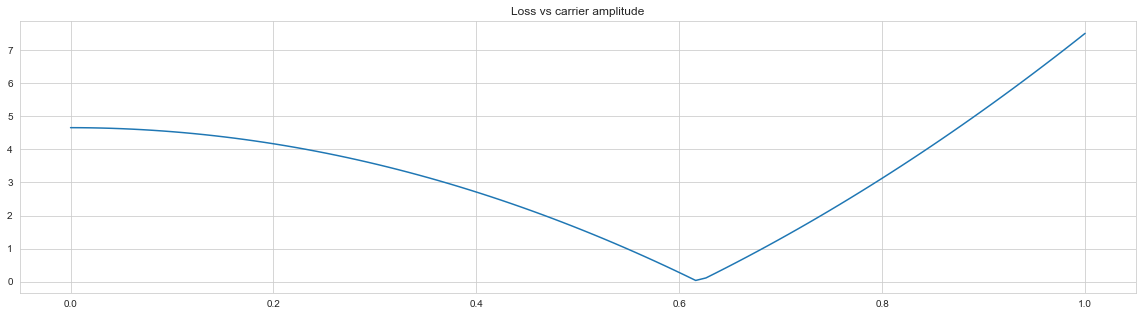

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(amp_vals, losses3)
plt.title("Loss vs carrier amplitude")
plt.show()

In [13]:
mod_index_vals = np.linspace(0, 0.3, 1000)

losses4 = []
for mod_index_val in mod_index_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'mod_index': mod_index_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses4.append(loss_val.detach().cpu().numpy().item())

print(losses4)

[5.364941120147705, 5.346414089202881, 5.331287860870361, 5.280294418334961, 5.230661869049072, 5.208610534667969, 5.188313961029053, 5.1786346435546875, 5.173122406005859, 5.143228054046631, 5.116969108581543, 5.098372459411621, 5.068577289581299, 5.0453691482543945, 5.027272701263428, 5.005029678344727, 4.985964775085449, 4.966480255126953, 4.962374687194824, 4.959030628204346, 4.92025089263916, 4.896514892578125, 4.85550594329834, 4.825334072113037, 4.796707630157471, 4.764009475708008, 4.730977535247803, 4.707486152648926, 4.6913886070251465, 4.6824774742126465, 4.676242351531982, 4.619733810424805, 4.5647053718566895, 4.521292686462402, 4.481647491455078, 4.448604106903076, 4.403841972351074, 4.3699469566345215, 4.345620632171631, 4.293215751647949, 4.245563983917236, 4.211604595184326, 4.1608710289001465, 4.087898254394531, 4.022508144378662, 3.963198184967041, 3.907655954360962, 3.8479580879211426, 3.7693898677825928, 3.6958088874816895, 3.636671543121338, 3.5791637897491455, 3.

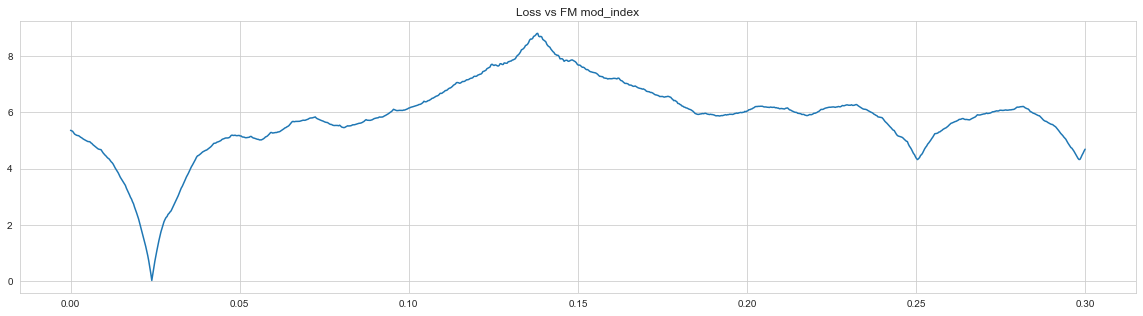

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(mod_index_vals, losses4)
plt.title("Loss vs FM mod_index")
plt.show()

In [15]:
sim_target_params = {'freq_c'}

KeyError: (0, 1)

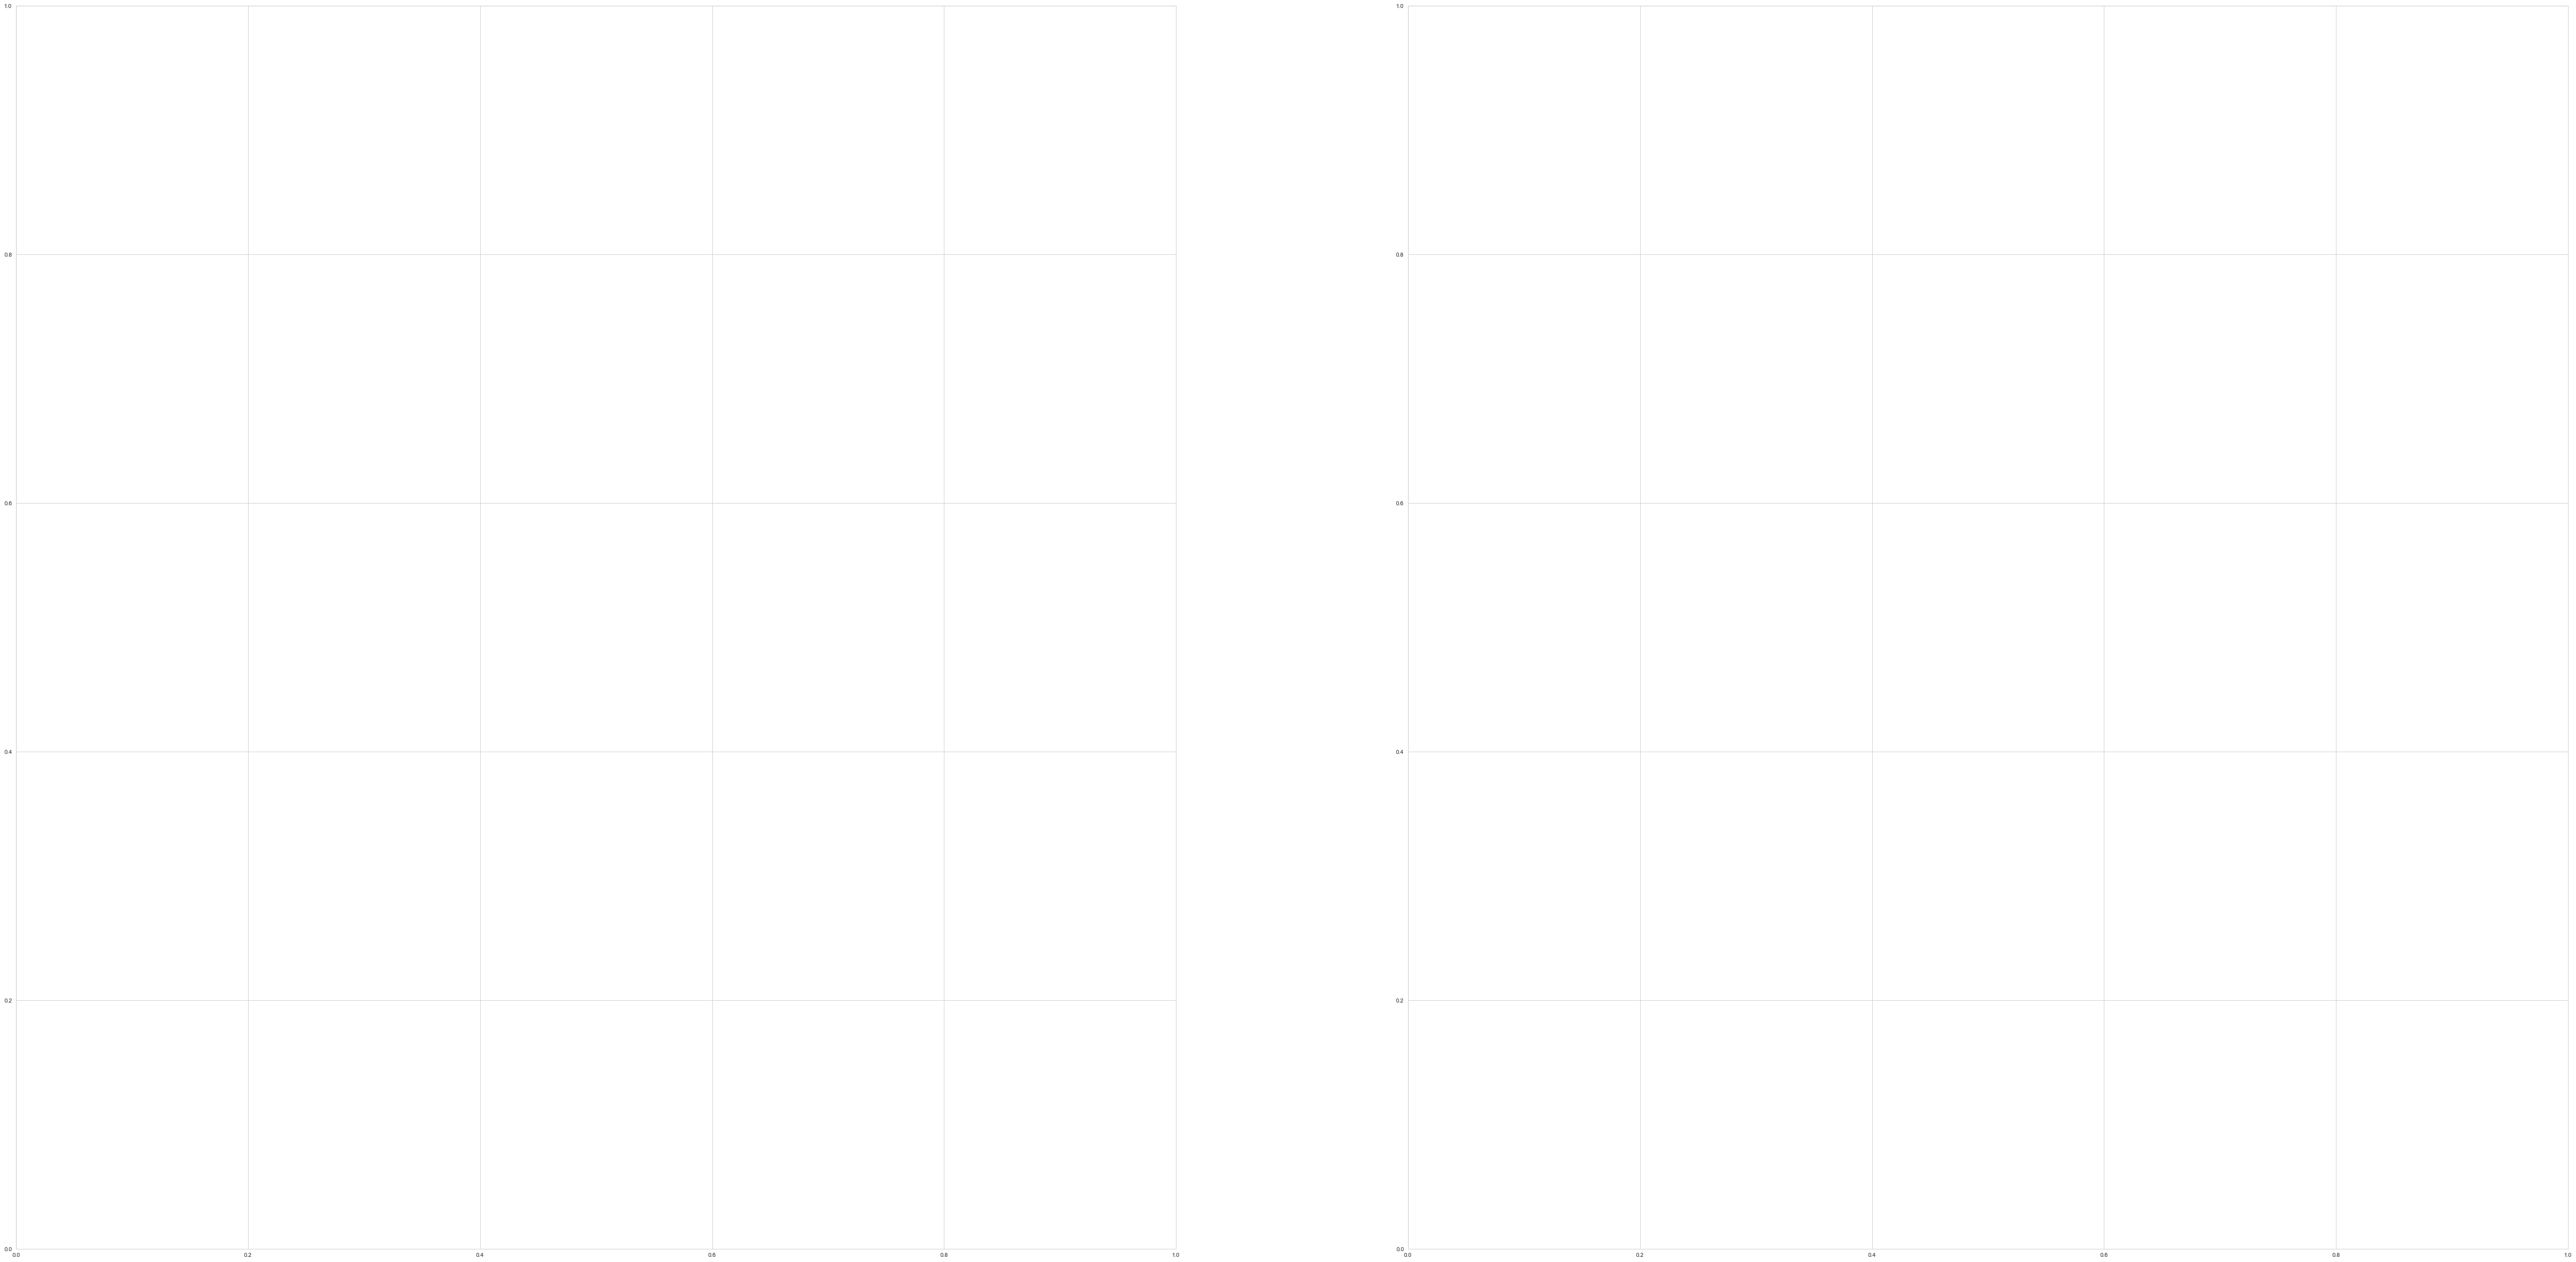

In [16]:
spec_op = Spectrogram(n_fft=512)


fig, ax = plt.subplots(1, 2, figsize=(80, 40))

target_spec = spec_op(target_signal.cpu())

update_params = copy.deepcopy(target_param_dict)

update_params[(0,1)]['parameters'].update({'freq_c': 200})
synth.update_cells_from_dict(update_params)
signal, _ = synth.generate_signal()

pred_spec = spec_op(signal.cpu().detach())

ax[0].imshow(target_spec.squeeze(), origin='lower')
ax[1].imshow(pred_spec.squeeze(), origin='lower')